In [1]:
import h5py
import numpy as np
import os,random
from keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from keras import layers
import keras.models as Model
from keras.regularizers import *
#from tensorflow.keras.optimizers import Adam
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"

2024-05-29 20:11:18.941692: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 20:11:18.966502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 20:11:19.339723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **数据集处理**

In [2]:
############################################
#由于硬件限制，无法使用完整数据集，因此我从完整数据集中抽取出部分数据，并分割成24个部分
#每部分对应一种调制，有1200*26=31200条数据
#因此，目前数据集大小为748800*1024*2
############################################
for i in range(0,24): #24个数据集文件
    ########打开文件#######
    filename = './ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    ########读取数据#######
    X_data = f['X'][:]
    Y_data = f['Y'][:]
    Z_data = f['Z'][:]
    f.close()
    #########分割训练集和测试集#########
    #每读取到一个数据文件就直接分割为训练集和测试集，防止爆内存
    n_examples = X_data.shape[0]
    n_train = int(n_examples * 0.7)   #70%训练样本
    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)#随机选取训练样本下标
    test_idx = list(set(range(0,n_examples))-set(train_idx))        #测试样本下标
    if i == 0:
        X_train = X_data[train_idx]
        Y_train = Y_data[train_idx]
        Z_train = Z_data[train_idx]
        X_test = X_data[test_idx]
        Y_test = Y_data[test_idx]
        Z_test = Z_data[test_idx]
    else:
        X_train = np.vstack((X_train, X_data[train_idx]))
        Y_train = np.vstack((Y_train, Y_data[train_idx]))
        Z_train = np.vstack((Z_train, Z_data[train_idx]))
        X_test = np.vstack((X_test, X_data[test_idx]))
        Y_test = np.vstack((Y_test, Y_data[test_idx]))
        Z_test = np.vstack((Z_test, Z_data[test_idx]))
print('训练集X维度：',X_train.shape)
print('训练集Y维度：',Y_train.shape)
print('训练集Z维度：',Z_train.shape)
print('测试集X维度：',X_test.shape)
print('测试集Y维度：',Y_test.shape)
print('测试集Z维度：',Z_test.shape)

./ExtractDataset/part0.h5
./ExtractDataset/part1.h5
./ExtractDataset/part2.h5
./ExtractDataset/part3.h5
./ExtractDataset/part4.h5
./ExtractDataset/part5.h5
./ExtractDataset/part6.h5
./ExtractDataset/part7.h5
./ExtractDataset/part8.h5
./ExtractDataset/part9.h5
./ExtractDataset/part10.h5
./ExtractDataset/part11.h5
./ExtractDataset/part12.h5
./ExtractDataset/part13.h5
./ExtractDataset/part14.h5
./ExtractDataset/part15.h5
./ExtractDataset/part16.h5
./ExtractDataset/part17.h5
./ExtractDataset/part18.h5
./ExtractDataset/part19.h5
./ExtractDataset/part20.h5
./ExtractDataset/part21.h5
./ExtractDataset/part22.h5
./ExtractDataset/part23.h5
训练集X维度： (524160, 1024, 2)
训练集Y维度： (524160, 24)
训练集Z维度： (524160, 1)
测试集X维度： (224640, 1024, 2)
测试集Y维度： (224640, 24)
测试集Z维度： (224640, 1)


snr: [-10]
Y [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


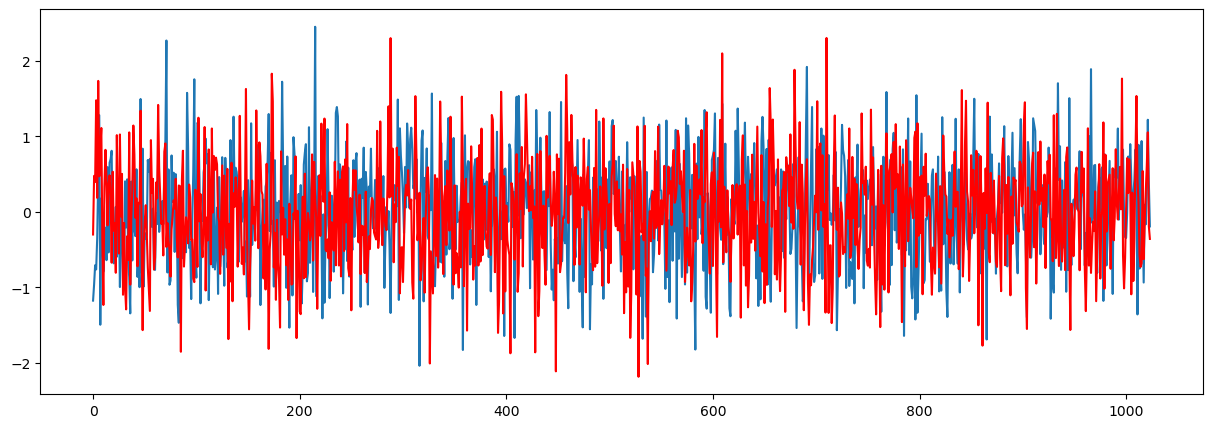

In [3]:
##查看数据是否正常
sample_idx = 520329 #随机下标
print('snr:',Z_train[sample_idx])
print('Y',Y_train[sample_idx])
plt_data = X_train[sample_idx].T
plt.figure(figsize=(15,5))
plt.plot(plt_data[0])
plt.plot(plt_data[1],color = 'red')
plt.show()

# **建立模型**

In [4]:
"""建立模型"""
classes = ['OOK',
           '4ASK',
           '8ASK',
           'BPSK',
           'QPSK',
           '8PSK',
           '16PSK',
           '32PSK',
           '16APSK',
           '32APSK',
           '64APSK',
           '128APSK',
           '16QAM',
           '32QAM',
           '64QAM',
           '128QAM',
           '256QAM',
           'AM-SSB-WC',
           'AM-SSB-SC',
           'AM-DSB-WC',
           'AM-DSB-SC',
           'FM',
           'GMSK',
           'OQPSK']
data_format = 'channels_first'

def residual_stack(Xm,kennel_size,Seq,pool_size):
    #1*1 Conv Linear
    Xm = Conv2D(32, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    #Residual Unit 1
    Xm_shortcut = Xm
    Xm = Conv2D(32, kennel_size, padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = Conv2D(32, kennel_size, padding='same', name=Seq+"_conv3", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = layers.add([Xm,Xm_shortcut])
    Xm = Activation("relu")(Xm)
    #Residual Unit 2
    Xm_shortcut = Xm
    Xm = Conv2D(32, kennel_size, padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = Conv2D(32, kennel_size, padding='same', name=Seq+"_conv5", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = layers.add([Xm,Xm_shortcut])
    Xm = Activation("relu")(Xm)
    #MaxPooling
    Xm = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='valid', data_format=data_format)(Xm)
    return Xm


in_shp = X_train.shape[1:]   #每个样本的维度[1024,2]
#input layer
Xm_input = Input(in_shp)
Xm = Reshape([1,1024,2], input_shape=in_shp)(Xm_input)
#Residual Srack
Xm = residual_stack(Xm,kennel_size=(3,2),Seq="ReStk0",pool_size=(2,2))   #shape:(512,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk1",pool_size=(2,1))   #shape:(256,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk2",pool_size=(2,1))   #shape:(128,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk3",pool_size=(2,1))   #shape:(64,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk4",pool_size=(2,1))   #shape:(32,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk5",pool_size=(2,1))   #shape:(16,1,32)

#############################################################################
#      多次尝试发现减少一层全连接层能使loss下降更快
#      将AlphaDropout设置为0.3似乎比0.5效果更好
#############################################################################
#Full Con 1
Xm = Flatten(data_format=data_format)(Xm)
Xm = Dense(128, activation='selu', kernel_initializer='glorot_normal', name="dense1")(Xm)
Xm = AlphaDropout(0.3)(Xm)
#Full Con 2
Xm = Dense(len(classes), kernel_initializer='glorot_normal', name="dense2")(Xm)
#SoftMax
Xm = Activation('softmax')(Xm)
#Create Model
model = Model.Model(inputs=Xm_input,outputs=Xm)
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 2)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 1024, 2)   0           ['input_1[0][0]']                
                                                                                                  
 ReStk0_conv1 (Conv2D)          (None, 32, 1024, 2)  64          ['reshape[0][0]']                
                                                                                                  
 ReStk0_conv2 (Conv2D)          (None, 32, 1024, 2)  6176        ['ReStk0_conv1[0][0]']           
                                                                                              

2024-05-29 20:11:33.468067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 20:11:33.484405: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# 检查GPU
#print(tf.test.gpu_device_name())

# 检查数据形状
#print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

# 检查是否有 None 值
#print(X_train is None, Y_train is None, X_test is None, Y_test is None)
# 调试信息
print(f"X_train type: {type(X_train)}, shape: {X_train.shape}")
print(f"Y_train type: {type(Y_train)}, shape: {Y_train.shape}")
print(f"X_test type: {type(X_test)}, shape: {X_test.shape}")
print(f"Y_test type: {type(Y_test)}, shape: {Y_test.shape}")

# 确保数据不为 None
assert X_train is not None, "X_train is None"
assert Y_train is not None, "Y_train is None"
assert X_test is not None, "X_test is None"
assert Y_test is not None, "Y_test is None"





X_train type: <class 'numpy.ndarray'>, shape: (524160, 1024, 2)
Y_train type: <class 'numpy.ndarray'>, shape: (524160, 24)
X_test type: <class 'numpy.ndarray'>, shape: (224640, 1024, 2)
Y_test type: <class 'numpy.ndarray'>, shape: (224640, 24)


In [6]:
# # 定义模型
# def get_model():
#     model = keras.models.Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=(1024, 2, 1)),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(64, activation='relu'),
#         Dense(24, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# model = get_model()

# print(tf.test.gpu_device_name())
# filepath = './Models/ResNet_Model_72w.keras'

In [7]:

# # 创建回调函数
# checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath, monitor='
# val_loss', verbose=0, save_best_only=True, mode='auto')
# early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
#  patience=10, verbose=0, mode='auto')

# # 确保回调函数不为 None
# assert checkpoint_callback is not None, "checkpoint_callback is None"
# assert early_stopping_callback is not None, "early_stopping_callback is Non
# e"

# # 打印回调函数的配置
# print(checkpoint_callback)
# print(early_stopping_callback)

# # 模型训练
# history = model.fit(
#     X_train,
#     Y_train,
#     batch_size=1000,
#     epochs=100,
#     verbose=2,
#     validation_data=(X_test, Y_test),
#     callbacks=[
#         checkpoint_callback,
#         early_stopping_callback
#     ]
# )

# # 重新加载最佳模型权重
# model.load_weights(filepath)



In [8]:
print(type(X_train))

<class 'numpy.ndarray'>


In [9]:
filepath = '/home/cjj/ResNet-for-Radio-Recognition-master/Models/ResNet_Model_72w.h5.keras'
print("X_train is None:", X_train is None)
print("Y_train is None:", Y_train is None)
print("X_test is None:", X_test is None)
print("Y_test is None:", Y_test is None)
print("filepath is None:", filepath is None)


X_train is None: False
Y_train is None: False
X_test is None: False
Y_test is None: False
filepath is None: False


# **训练**

In [10]:
"""训练模型"""
#############################################################################
#      当val_loss连续10次迭代不再减小或总迭代次数大于100时停止
#      将最小验证损失的模型保存
#############################################################################
print(tf.test.gpu_device_name())

history = model.fit(X_train,
    Y_train,
    batch_size=1000,
    epochs=100,
    verbose=2,
    validation_data=(X_test, Y_test),
    #validation_split = 0.3,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

2024-05-29 20:11:33.691853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 20:11:33.691944: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



Epoch 1/100


KeyboardInterrupt: 

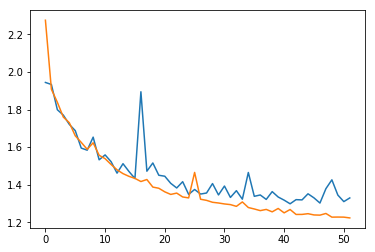

In [ ]:
val_loss_list = history.history['val_loss']
loss_list = history.history['loss']
plt.plot(range(len(loss_list)),val_loss_list)
plt.plot(range(len(loss_list)),loss_list)
plt.show()

In [ ]:
##########从loss走势来看，预计loss还能继续下降，故再训练一次#######
history = model.fit(X_train,
    Y_train,
    batch_size=1000,
    epochs=100,
    verbose=2,
    validation_data=(X_test, Y_test),
    #validation_split = 0.3,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 524160 samples, validate on 224640 samples
Epoch 1/100
 - 171s - loss: 1.2541 - val_loss: 1.3146
Epoch 2/100
 - 171s - loss: 1.2408 - val_loss: 1.3082
Epoch 3/100
 - 170s - loss: 1.2421 - val_loss: 1.3511
Epoch 4/100
 - 170s - loss: 1.2355 - val_loss: 1.3351
Epoch 5/100
 - 171s - loss: 1.2318 - val_loss: 1.3322
Epoch 6/100
 - 170s - loss: 1.2332 - val_loss: 1.3297
Epoch 7/100
 - 170s - loss: 1.2614 - val_loss: 1.3080
Epoch 8/100
 - 171s - loss: 1.2267 - val_loss: 1.3170
Epoch 9/100
 - 170s - loss: 1.2202 - val_loss: 1.2851
Epoch 10/100
 - 171s - loss: 1.2236 - val_loss: 1.3395
Epoch 11/100
 - 170s - loss: 1.2195 - val_loss: 1.3085
Epoch 12/100
 - 170s - loss: 1.2327 - val_loss: 1.2971
Epoch 13/100
 - 170s - loss: 1.2161 - val_loss: 1.3330
Epoch 14/100
 - 170s - loss: 1.2148 - val_loss: 1.3075
Epoch 15/100
 - 170s - loss: 1.2122 - val_loss: 1.3032
Epoch 16/100
 - 171s - loss: 1.2122 - val_loss: 1.2998
Epoch 17/100
 - 170s - loss: 1.2132 - val_loss: 1.3888
Epoch 18/100
 - 170s -

# **测试**

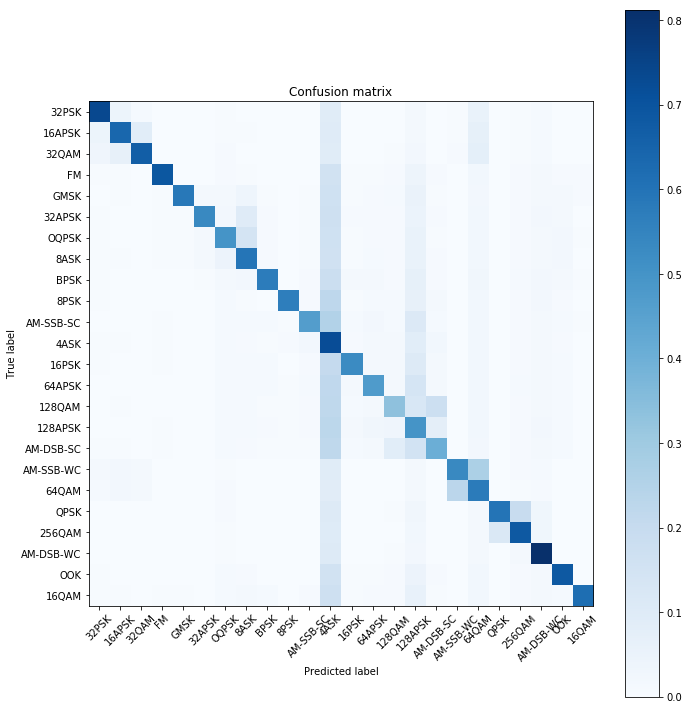

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=1024)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.7341880341880341
16APSK 0.6400641025641025
32QAM 0.667094017094017
FM 0.6900641025641026
GMSK 0.5853632478632479
32APSK 0.5334401709401709
OQPSK 0.5003205128205128
8ASK 0.5936965811965812
BPSK 0.5711538461538461
8PSK 0.5662393162393162
AM-SSB-SC 0.46324786324786327
4ASK 0.7215811965811966
16PSK 0.5289529914529915
64APSK 0.4738247863247863
128QAM 0.33376068376068374
128APSK 0.5010683760683761
AM-DSB-SC 0.4028846153846154
AM-SSB-WC 0.5333333333333333
64QAM 0.5747863247863247
QPSK 0.5967948717948718
256QAM 0.683974358974359
AM-DSB-WC 0.811965811965812
OOK 0.684508547008547
16QAM 0.6159188034188035


Overall Accuracy -20:  0.04002784545770971
Overall Accuracy -18:  0.04501022959763583
Overall Accuracy -16:  0.04807135410633615
Overall Accuracy -14:  0.05272727272727273
Overall Accuracy -12:  0.07741411327762303
Overall Accuracy -10:  0.11182220153595532
Overall Accuracy -8:  0.1725139405204461
Overall Accuracy -6:  0.21873175289034216
Overall Accuracy -4:  0.2922161279029058
Overall Accuracy -2:  0.3717223056486081


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Overall Accuracy 0:  0.48072768618533257
Overall Accuracy 2:  0.5804292637895223
Overall Accuracy 4:  0.7028909787530477
Overall Accuracy 6:  0.8048864418444598
Overall Accuracy 8:  0.8704663212435233
Overall Accuracy 10:  0.9200459506031017
Overall Accuracy 12:  0.9353753335653788
Overall Accuracy 14:  0.9395941481831053
Overall Accuracy 16:  0.9387731614685234
Overall Accuracy 18:  0.9412920374436612
Overall Accuracy 20:  0.9449849432476257
Overall Accuracy 22:  0.9385317878468563
Overall Accuracy 24:  0.9427409988385598
Overall Accuracy 26:  0.9436931685707625
Overall Accuracy 28:  0.9414466130884042
Overall Accuracy 30:  0.9393475444588387


<Figure size 432x288 with 0 Axes>

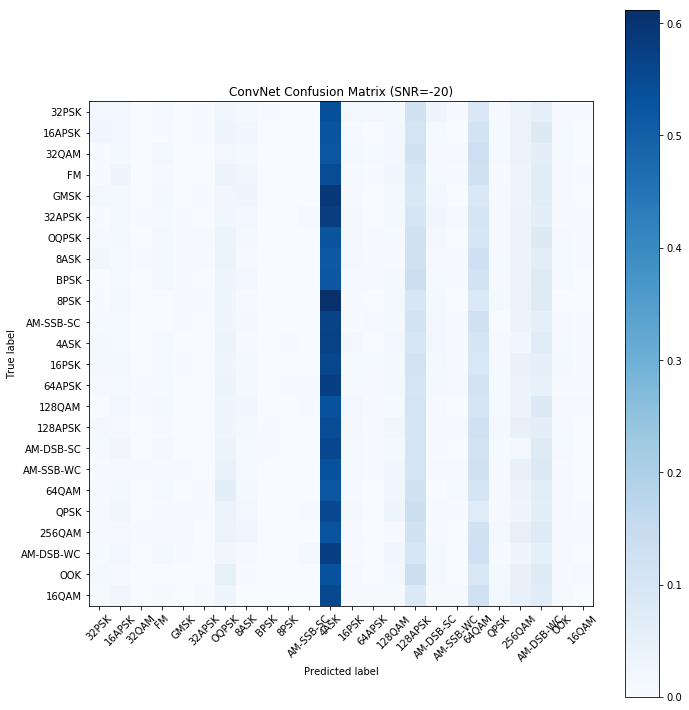

<Figure size 432x288 with 0 Axes>

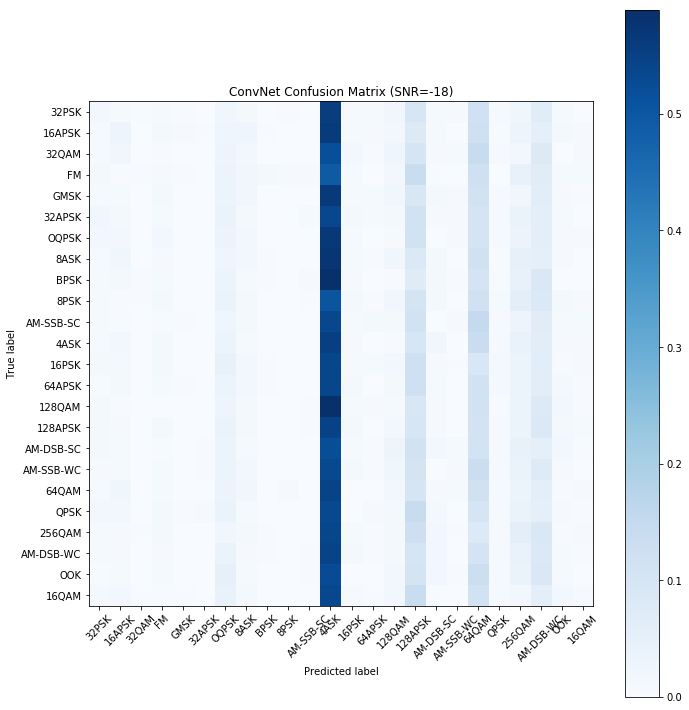

<Figure size 432x288 with 0 Axes>

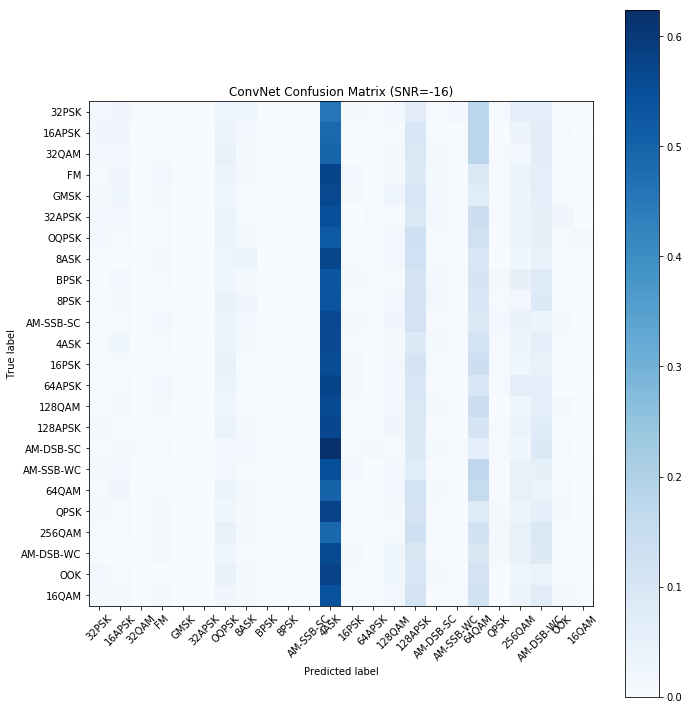

<Figure size 432x288 with 0 Axes>

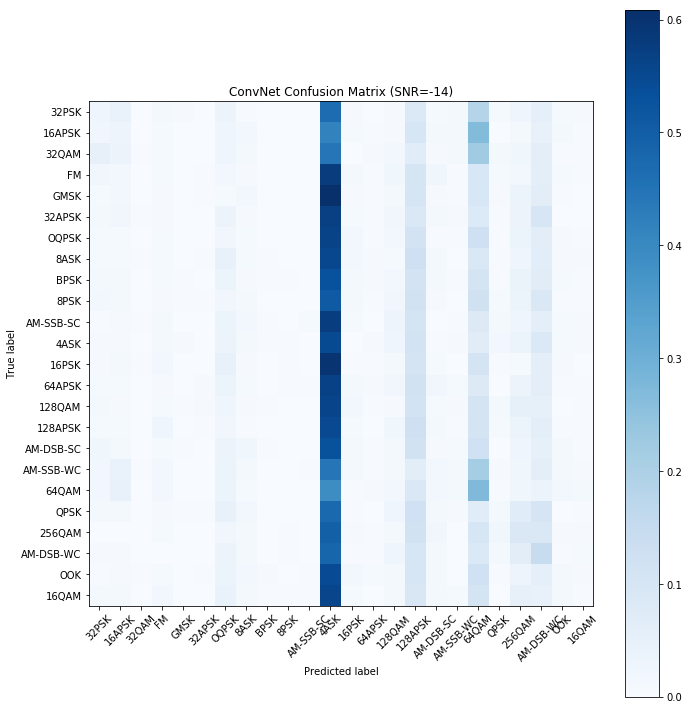

<Figure size 432x288 with 0 Axes>

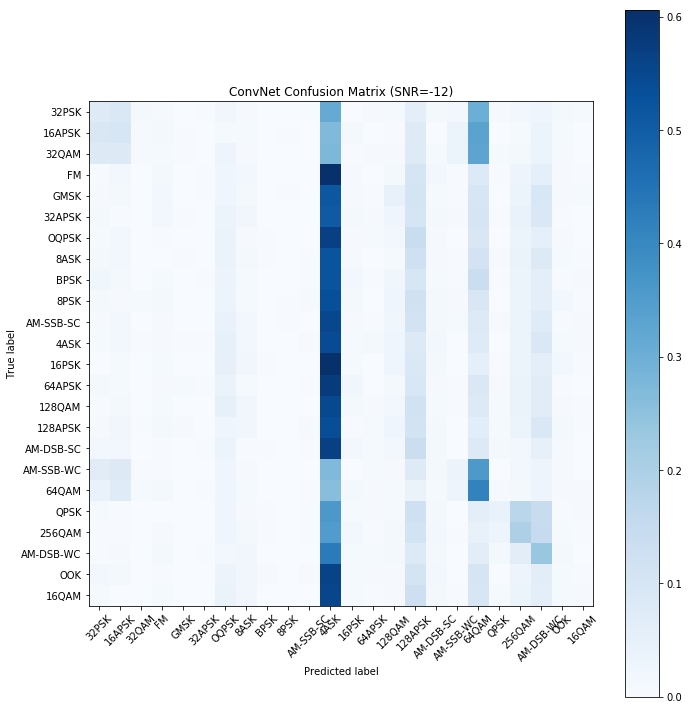

<Figure size 432x288 with 0 Axes>

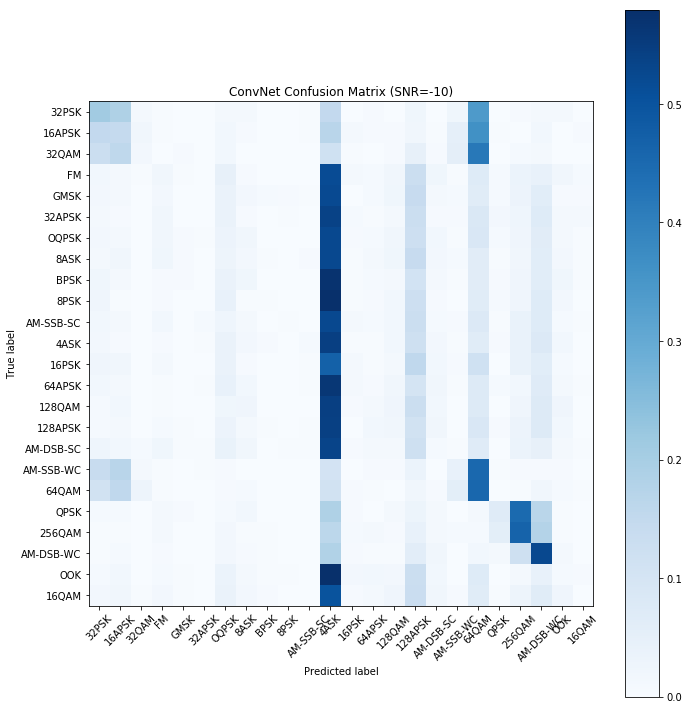

<Figure size 432x288 with 0 Axes>

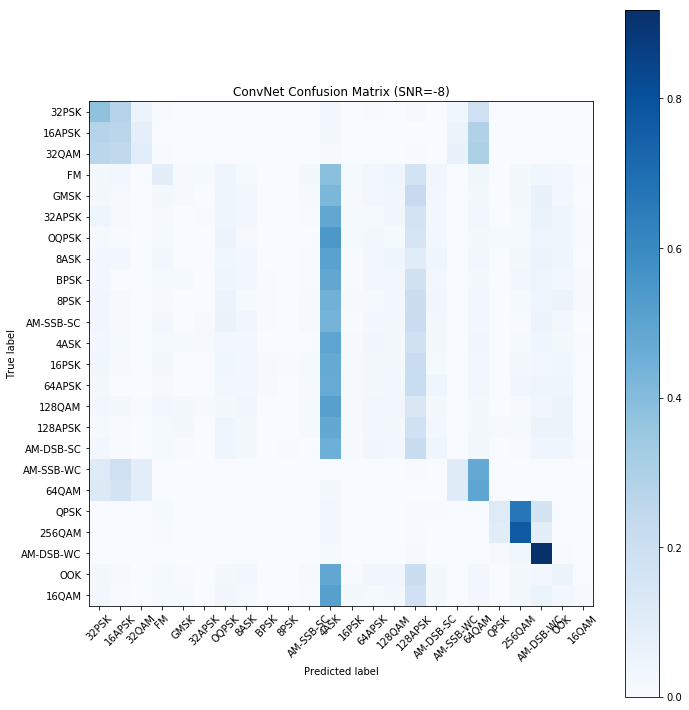

<Figure size 432x288 with 0 Axes>

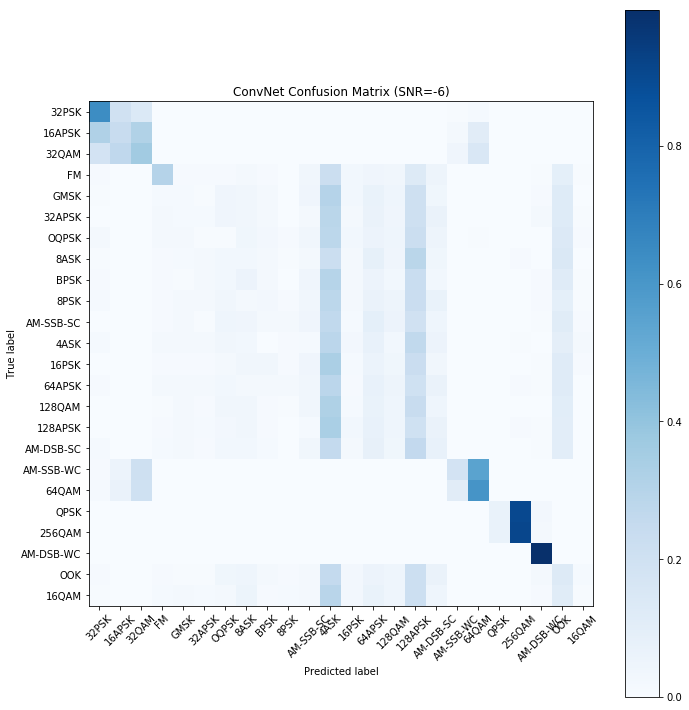

<Figure size 432x288 with 0 Axes>

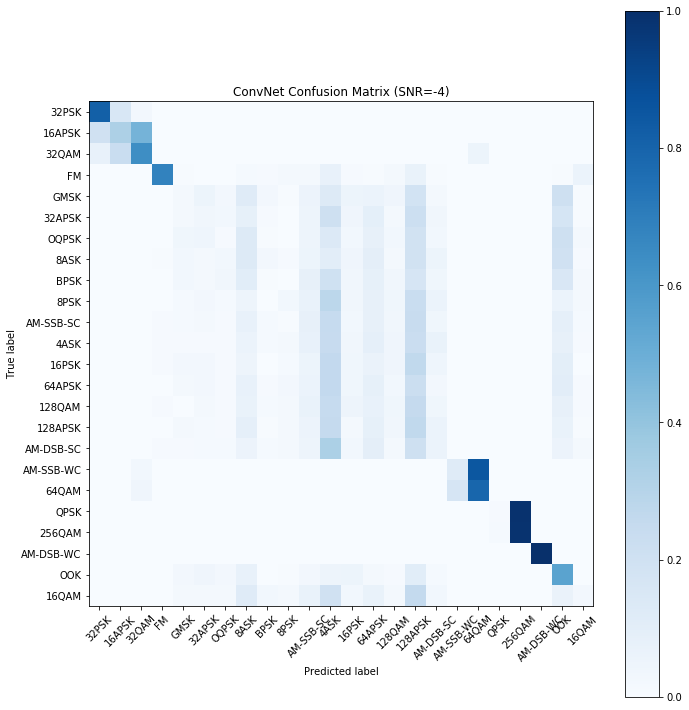

<Figure size 432x288 with 0 Axes>

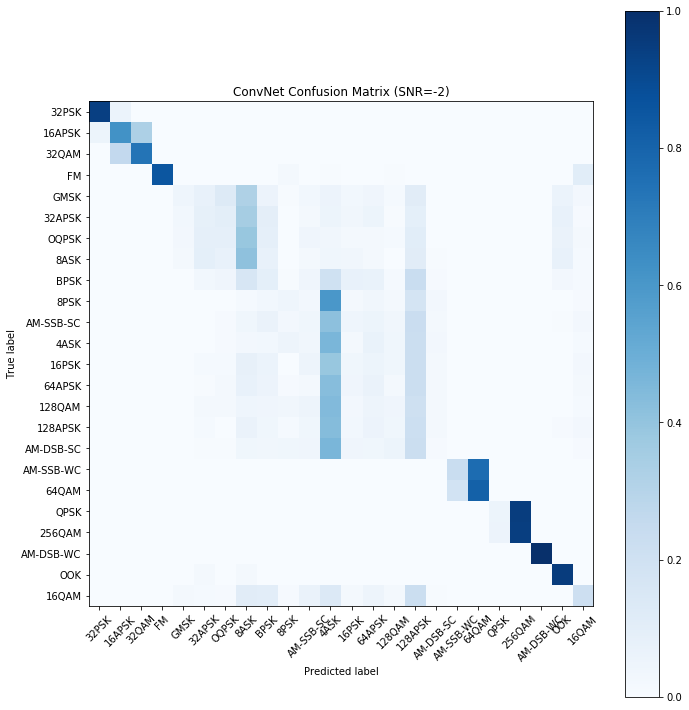

<Figure size 432x288 with 0 Axes>

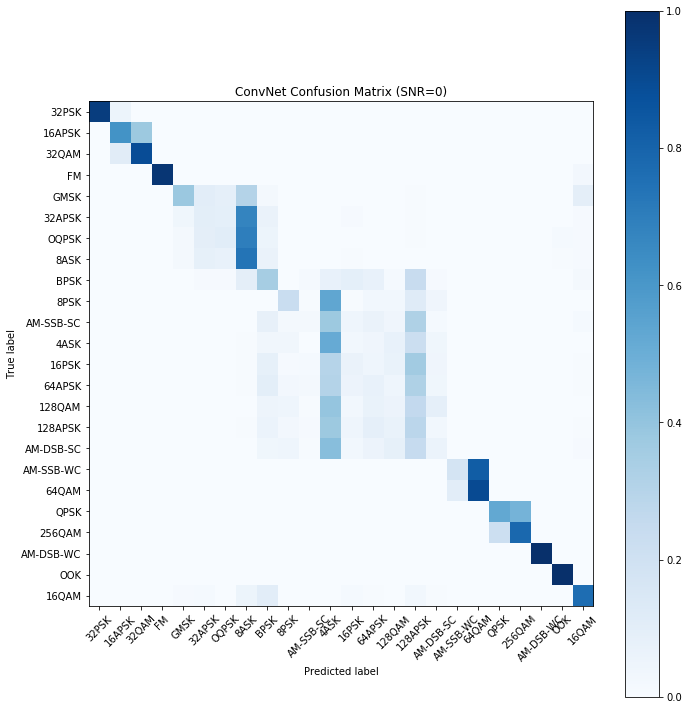

<Figure size 432x288 with 0 Axes>

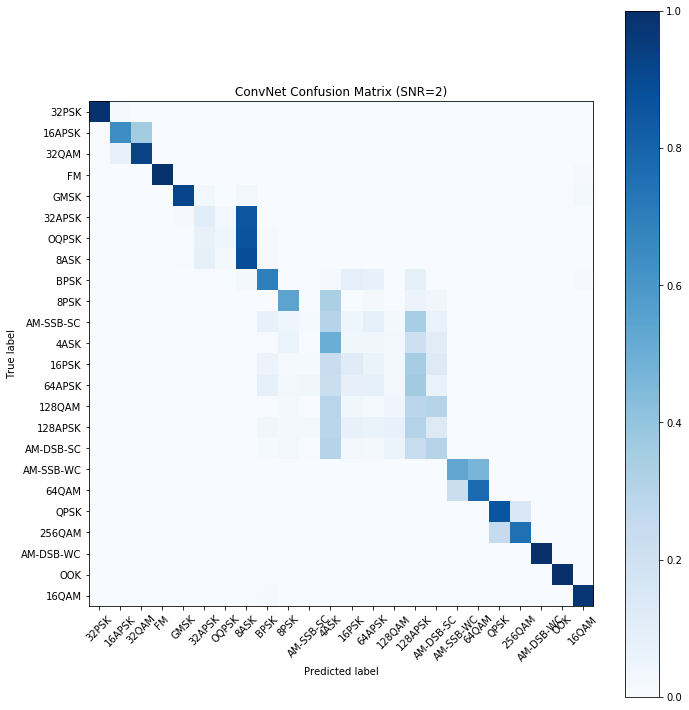

<Figure size 432x288 with 0 Axes>

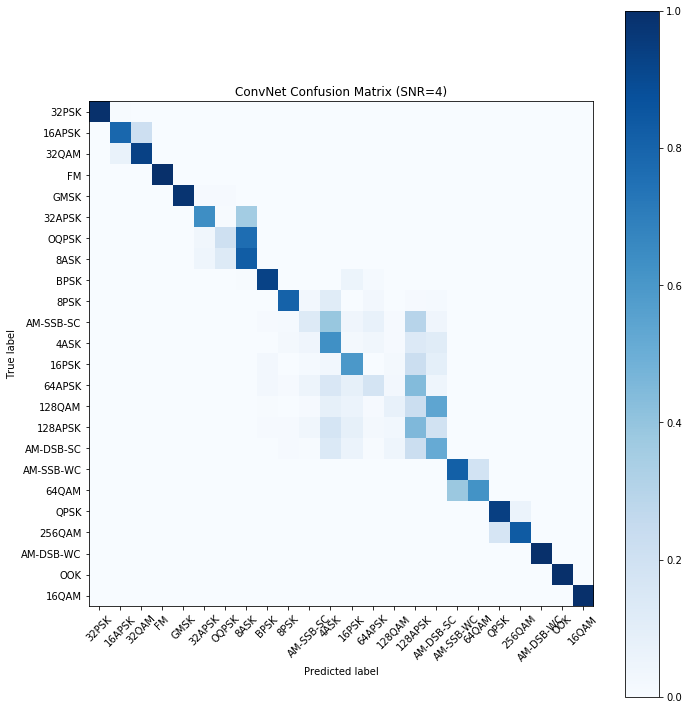

<Figure size 432x288 with 0 Axes>

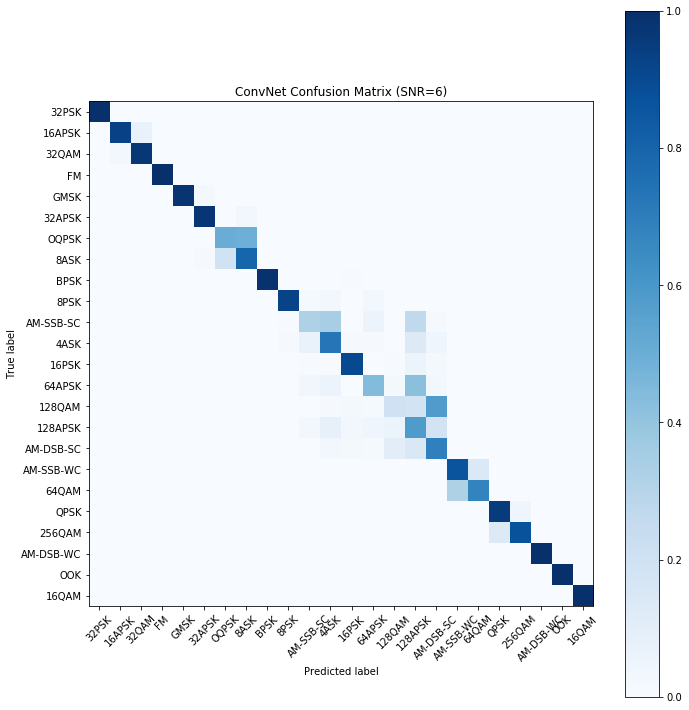

<Figure size 432x288 with 0 Axes>

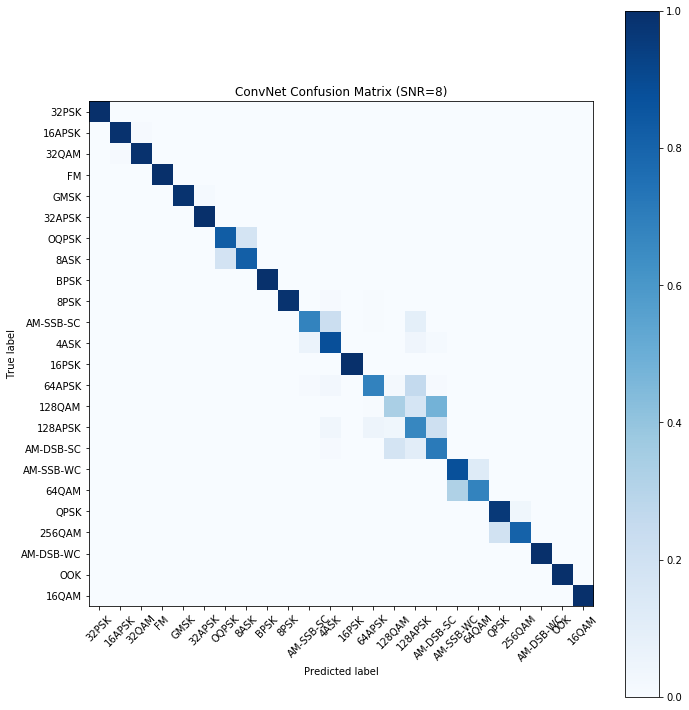

<Figure size 432x288 with 0 Axes>

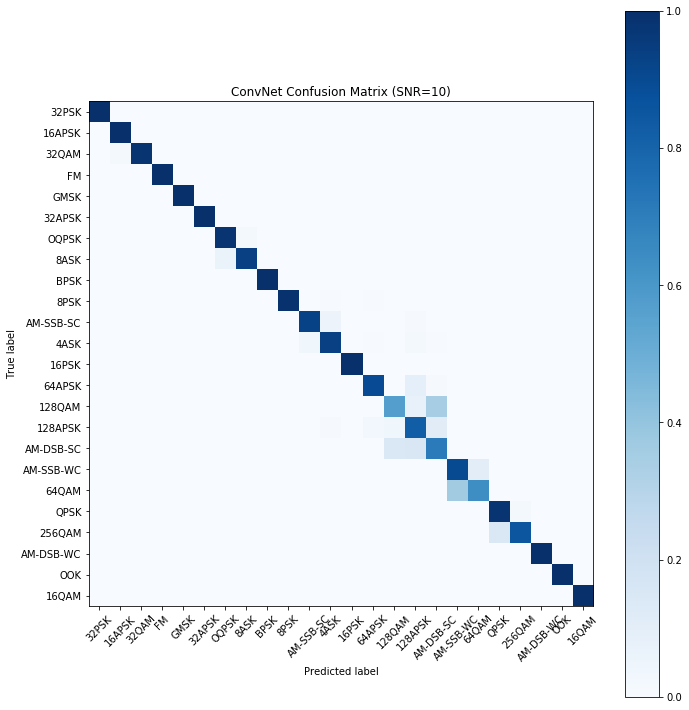

<Figure size 432x288 with 0 Axes>

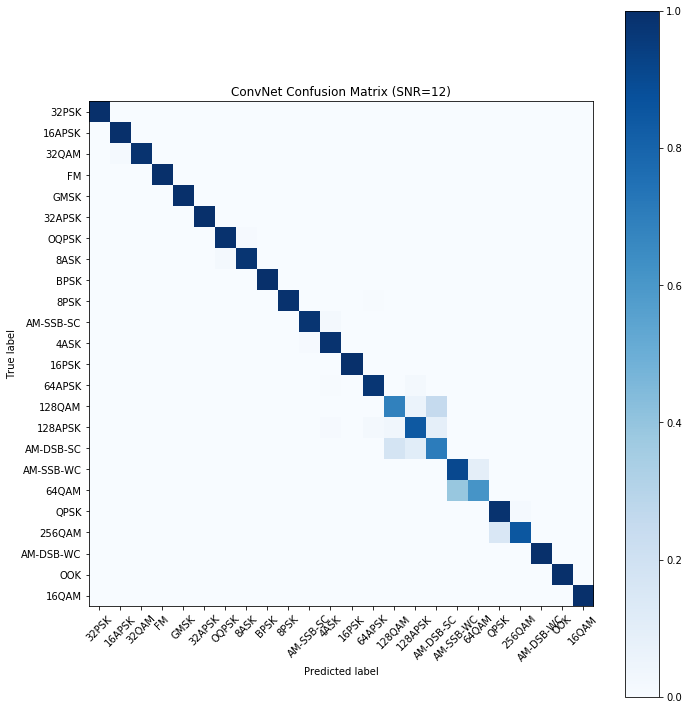

<Figure size 432x288 with 0 Axes>

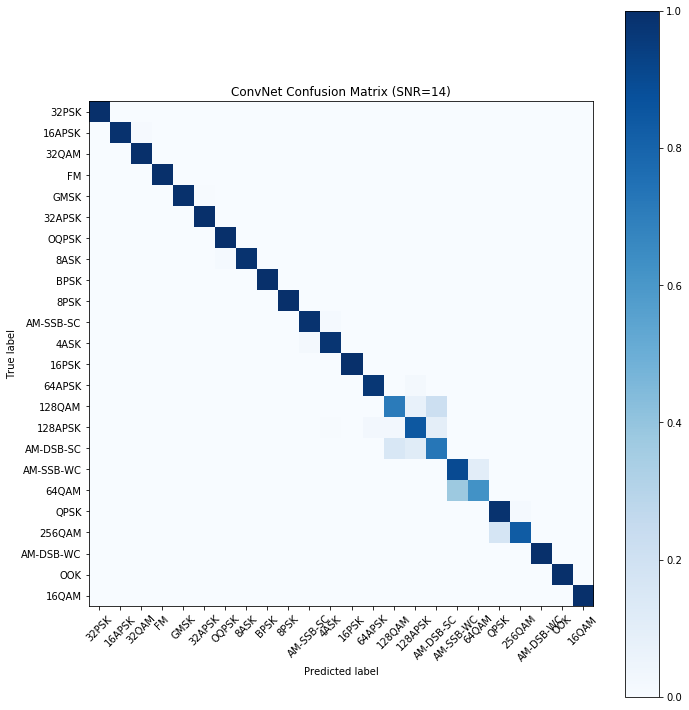

<Figure size 432x288 with 0 Axes>

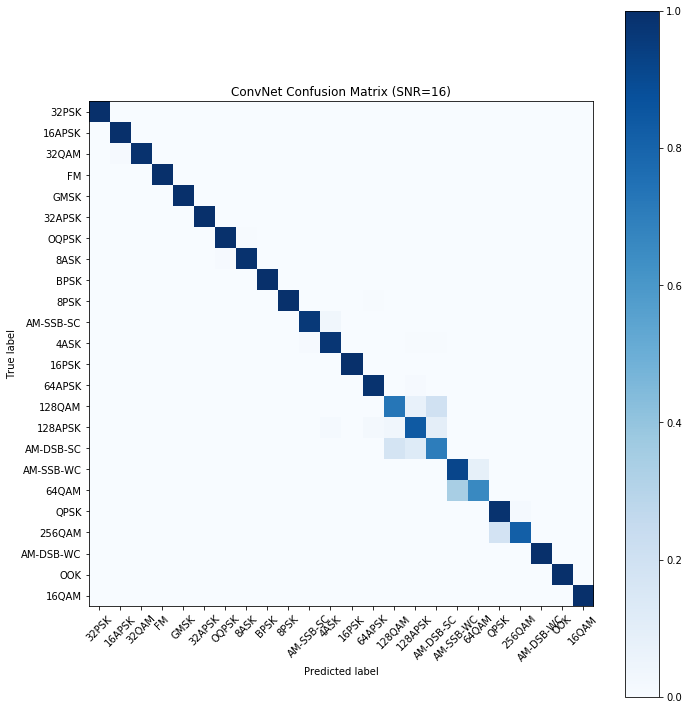

<Figure size 432x288 with 0 Axes>

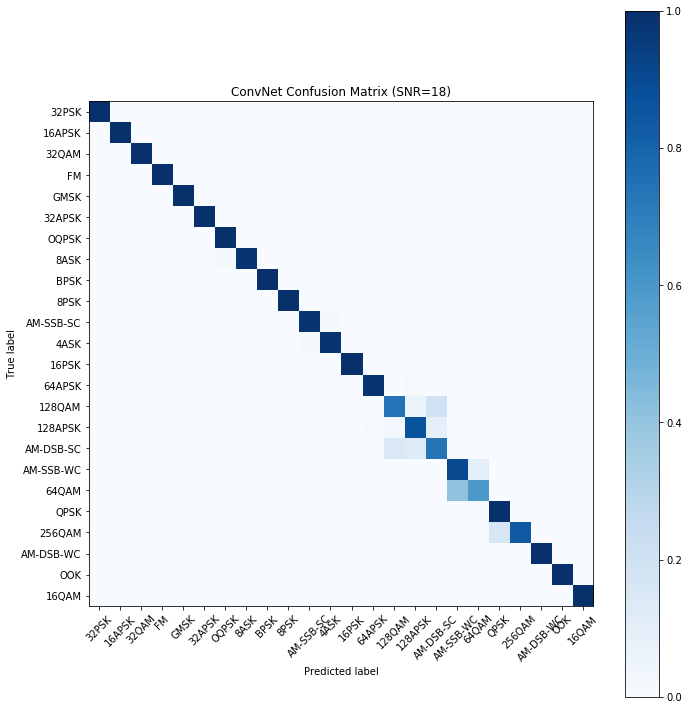

<Figure size 432x288 with 0 Axes>

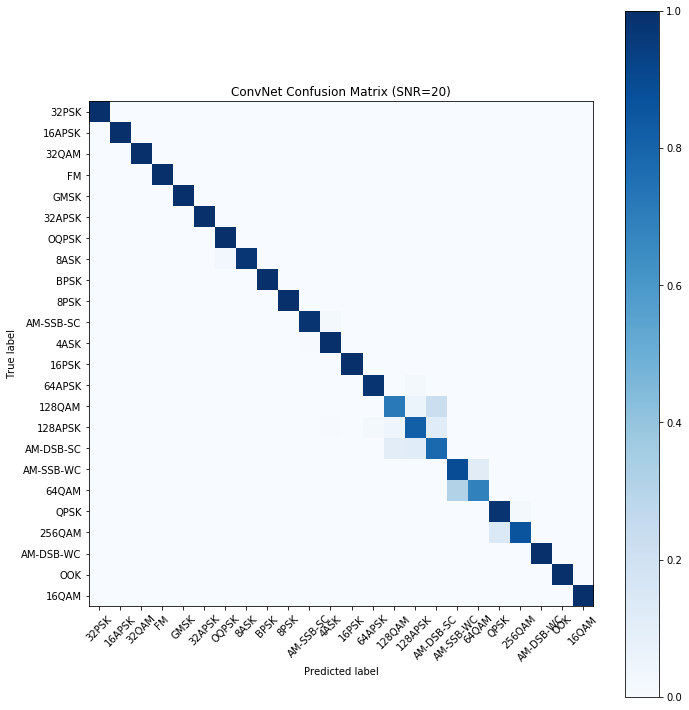

<Figure size 432x288 with 0 Axes>

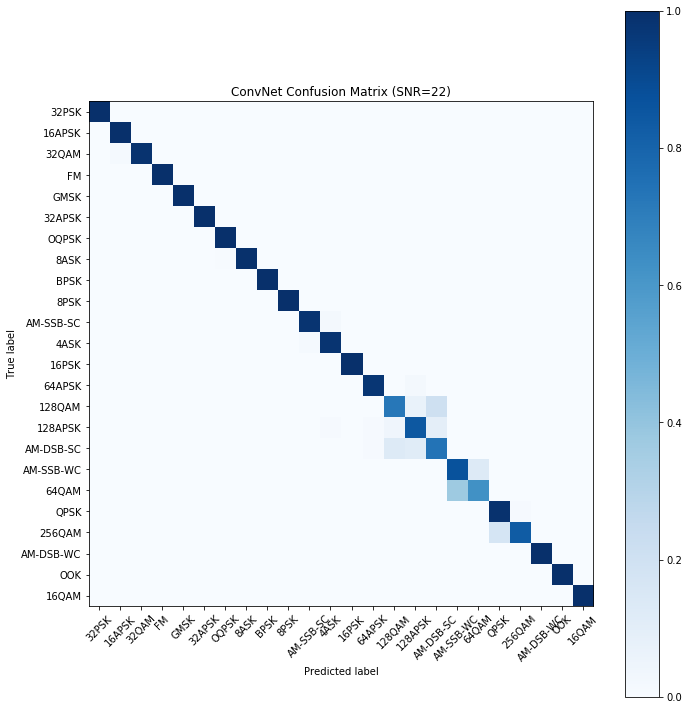

<Figure size 432x288 with 0 Axes>

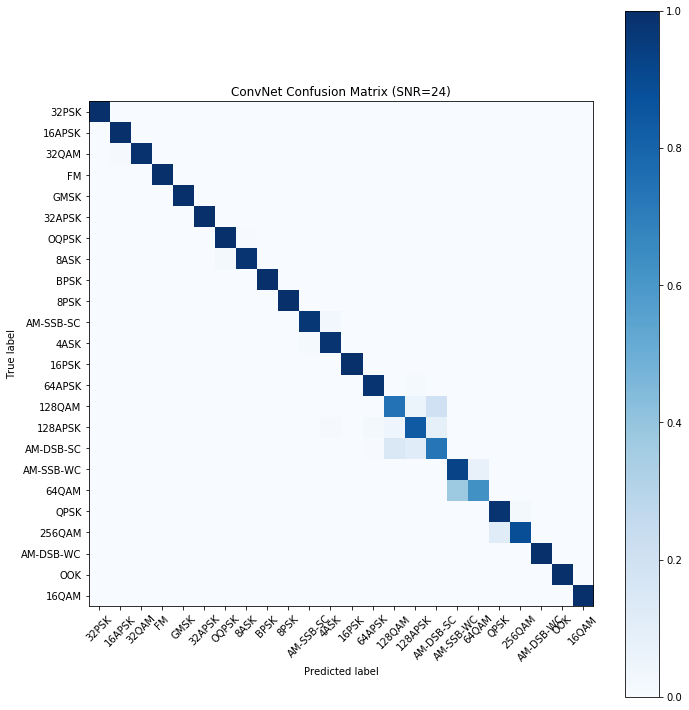

<Figure size 432x288 with 0 Axes>

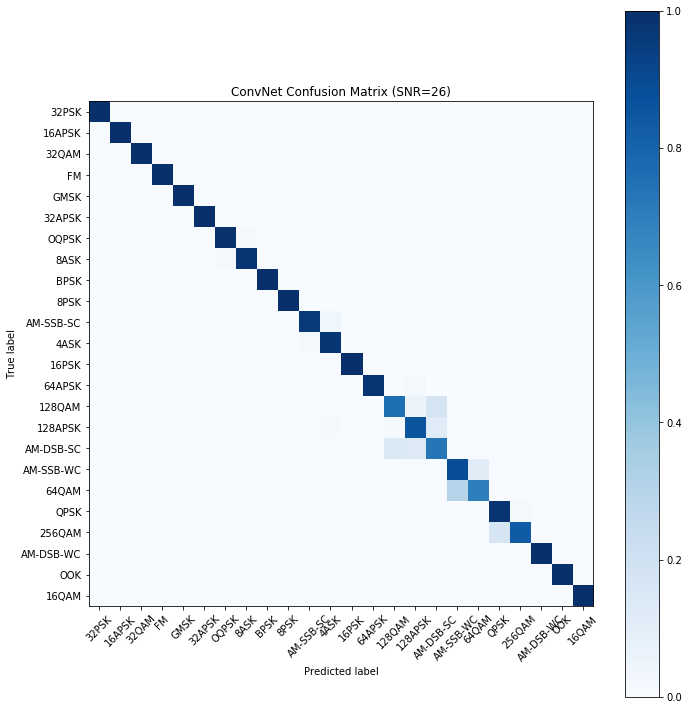

<Figure size 432x288 with 0 Axes>

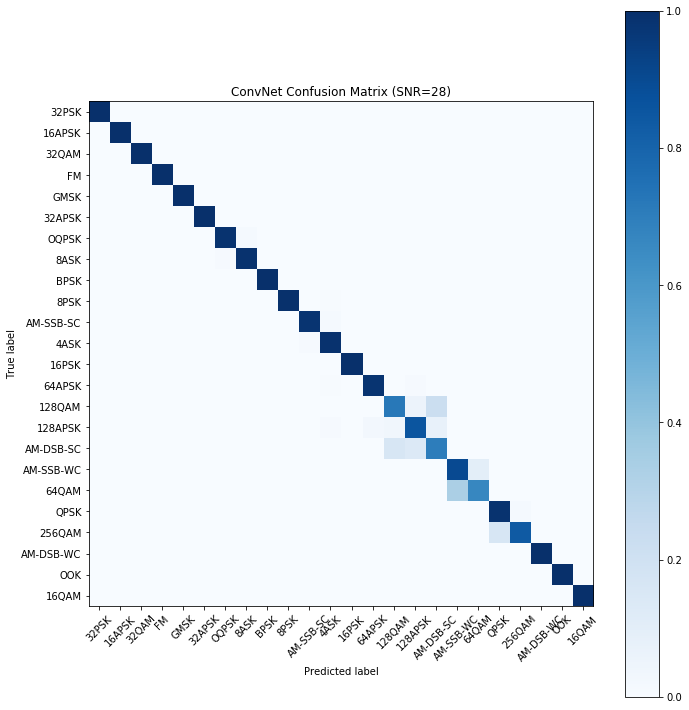

<Figure size 432x288 with 0 Axes>

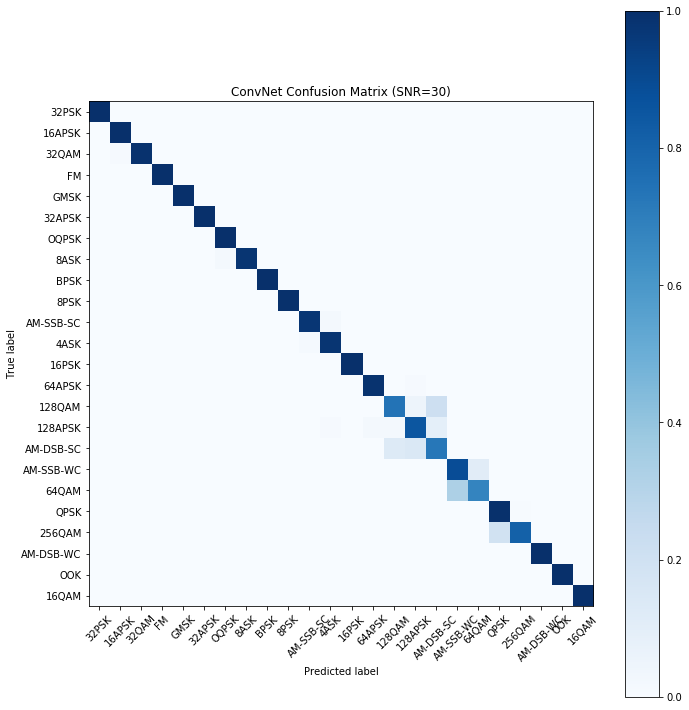

In [ ]:
acc={}
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #该信噪比下测试数据量
        j = list(Y_test_snr[i,:]).index(1)   #正确类别下标
        j = classes.index(classes[j])
        k = int(np.argmax(pre_Y_test[i,:])) #预测类别下标
        k = classes.index(classes[k])
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

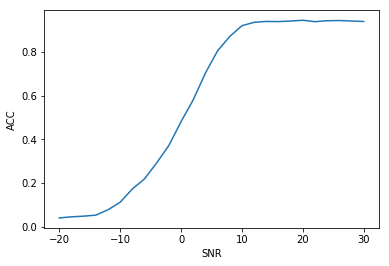

In [ ]:
plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.show()